In [1]:
! cd /kaggle/working/
! pwd

/kaggle/working


In [78]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"GPU AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU')) > 0}")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU devices: {gpus}")
    except RuntimeError as e:
        print(e)

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from os import listdir
from os.path import isfile, join
from pathlib import Path

from sklearn.model_selection import train_test_split
from skimage import io
import random
from skimage import transform
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import cv2

GPU AVAILABLE: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ADVANCED DATASET EXPLORATION
Original images: 400
Label images: 400
Image dimensions: (1056, 704)
Number of classes: 24



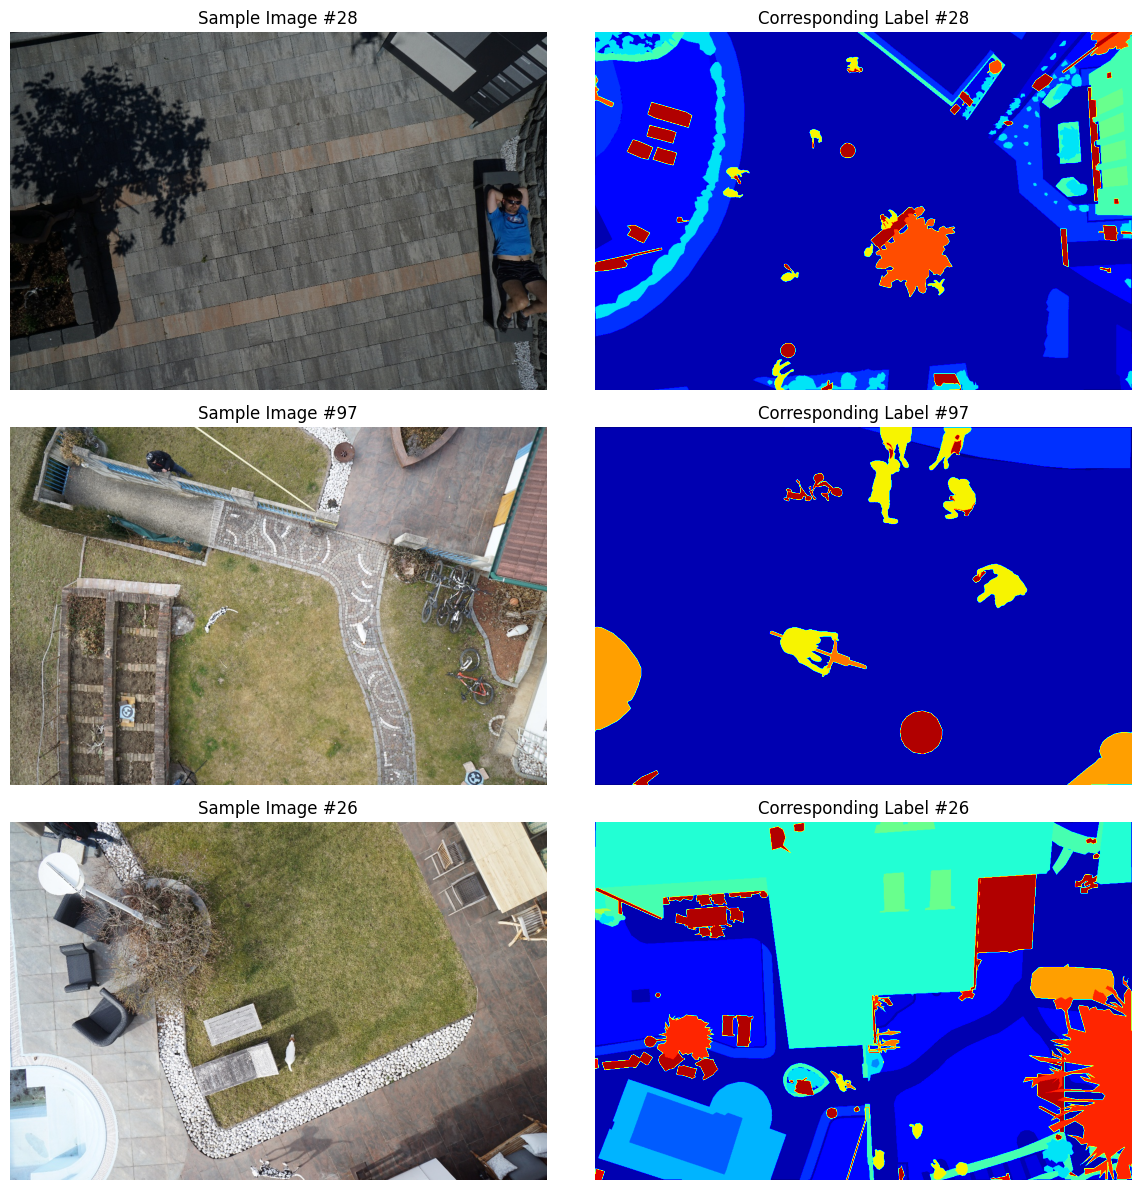

Calculating class distribution on entire label set...
    class_id  pixel_count  percentage
0          0       507688    0.170726
1          1    112133073   37.708318
2          2      9547065    3.210505
3          3     59472235   19.999433
4          4     21691202    7.294358
5          5      6672414    2.243812
6          6      2208846    0.742795
7          7      1996214    0.671291
8          8     21033595    7.073216
9          9     21925174    7.373038
10        10      7984969    2.685200
11        11      1689153    0.568032
12        12       124264    0.041788
13        13      2844873    0.956679
14        14       177000    0.059522
15        15      3115649    1.047736
16        16        63403    0.021321
17        17      2355595    0.792144
18        18       653701    0.219828
19        19      6094870    2.049594
20        20      3958734    1.331250
21        21       692741    0.232956
22        22     10427142    3.506459
23        23            0    0.000

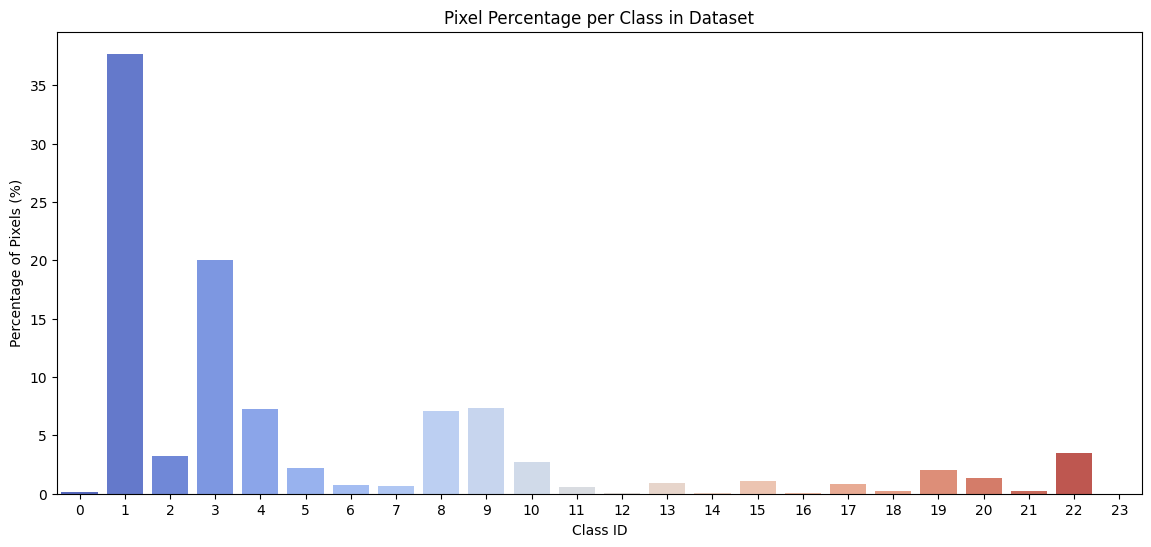

Class with max pixels: class_id       1.000000e+00
pixel_count    1.121331e+08
percentage     3.770832e+01
Name: 1, dtype: float64

Class with min pixels: class_id       23.0
pixel_count     0.0
percentage      0.0
Name: 23, dtype: float64

Average image brightness: 111.81 (std: 15.71)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


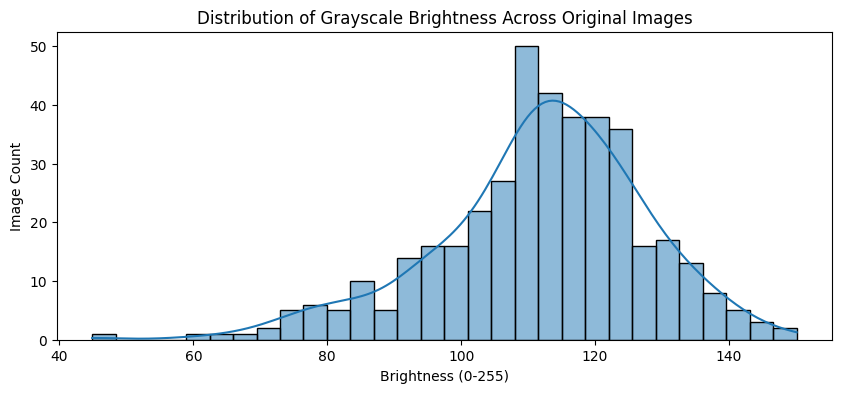

In [80]:
def advanced_explore_dataset():
    print("="*50)
    print("ADVANCED DATASET EXPLORATION")
    print("="*50)
    
    original_path = Path("./original_images")
    label_path = Path("./label_images_semantic")
    
    original_files = list(original_path.glob("*.jpg"))
    label_files = list(label_path.glob("*.png"))
    
    print(f"Original images: {len(original_files)}")
    print(f"Label images: {len(label_files)}")
    print(f"Image dimensions: {(1056, 704)}")
    print(f"Number of classes: {24}\n")
    
    if len(original_files) == 0 or len(label_files) == 0:
        print("No images or labels found for detailed EDA.")
        return
    
    sample_indices = np.random.choice(len(original_files), 3, replace=False)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    for i, idx in enumerate(sample_indices):
        img = cv2.imread(str(original_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread(str(label_files[idx]), cv2.IMREAD_GRAYSCALE)
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Sample Image #{idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(label, cmap='jet', vmin=0, vmax=23)
        axes[i, 1].set_title(f"Corresponding Label #{idx}")
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Calculating class distribution on entire label set...")
    class_counts = np.zeros(24, dtype=np.int64)
    for label_file in label_files:
        label_img = cv2.imread(str(label_file), cv2.IMREAD_GRAYSCALE)
        unique, counts = np.unique(label_img, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c
    
    total_pixels = class_counts.sum()
    class_percentages = class_counts / total_pixels * 100
    
    class_df = pd.DataFrame({
        'class_id': range(24),
        'pixel_count': class_counts,
        'percentage': class_percentages
    })
    print(class_df)
    
    plt.figure(figsize=(14,6))
    sns.barplot(x='class_id', y='percentage', data=class_df, palette='coolwarm')
    plt.title('Pixel Percentage per Class in Dataset')
    plt.xlabel('Class ID')
    plt.ylabel('Percentage of Pixels (%)')
    plt.savefig("./distribution_pixel_percentage_by_class.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    
    print(f"Class with max pixels: {class_df.loc[class_df.pixel_count.idxmax()]}\n")
    print(f"Class with min pixels: {class_df.loc[class_df.pixel_count.idxmin()]}\n")
    
    brightness_vals = []
    for img_file in original_files:
        img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        brightness_vals.append(np.mean(img))
    print(f"Average image brightness: {np.mean(brightness_vals):.2f} (std: {np.std(brightness_vals):.2f})")
    
    plt.figure(figsize=(10,4))
    sns.histplot(brightness_vals, bins=30, kde=True)
    plt.title('Distribution of Grayscale Brightness Across Original Images')
    plt.xlabel('Brightness (0-255)')
    plt.ylabel('Image Count')
    plt.savefig("./distribution_grayscale_brightness.png", dpi=300, bbox_inches="tight")
    plt.show()

advanced_explore_dataset()

In [ ]:
CLASS_COLORS = {
    0: [0, 0, 0],          # unlabeled
    1: [128, 64, 128],     # paved-area
    2: [244, 35, 232],     # dirt
    3: [70, 70, 70],       # grass
    4: [102, 102, 156],    # gravel
    5: [190, 153, 153],    # water
    6: [153, 153, 153],    # rocks
    7: [250, 170, 30],     # pool
    8: [220, 220, 0],      # vegetation
    9: [107, 142, 35],     # roof
    10: [152, 251, 152],   # wall
    11: [70, 130, 180],    # window
    12: [220, 20, 60],     # door
    13: [255, 0, 0],       # fence
    14: [0, 0, 142],       # fence-pole
    15: [0, 0, 70],        # person
    16: [0, 60, 100],      # dog
    17: [0, 80, 100],      # car
    18: [0, 0, 230],       # bicycle
    19: [119, 11, 32],     # tree
    20: [81, 0, 81],       # bald-tree
    21: [128, 64, 64],     # ar-marker
    22: [244, 35, 232],    # obstacle
    23: [250, 170, 160]    # conflicting
}

def get_rgb_representation():
    rgb_array = np.zeros((24, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        if class_id < CONFIG['n_classes']:
            rgb_array[class_id] = color
    return rgb_array

def print_legend():
    class_names = [
        'unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water',
        'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window',
        'door', 'fence', 'fence-pole', 'person', 'dog', 'car',
        'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting'
    ]
    
    print("\nClass Legend:")
    print("-" * 30)
    for i, name in enumerate(class_names[:24):
        color = CLASS_COLORS.get(i, [0, 0, 0])
        print(f"Class {i:2d}: {name:<15} RGB{color}")

rgb_representations = get_rgb_representation()
print_legend()

In [4]:
try:
    os.mkdir('./label_images_semantic')
except Exception as e:
    print(e)
try:
    os.mkdir('./original_images')
except Exception as e:
    print(e)

source_path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/'

if os.path.exists(source_path + 'label_images_semantic'):
    for image_filename in tqdm(os.listdir(source_path + 'label_images_semantic')):
        image = cv2.imread(source_path + 'label_images_semantic/' + image_filename, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (1056, 704))
            cv2.imwrite('./label_images_semantic/' + image_filename, image)
   
if os.path.exists(source_path + 'original_images'):
    for image_filename in tqdm(os.listdir(source_path + 'original_images')):
        image = cv2.imread(source_path + 'original_images/' + image_filename)
        if image is not None:
            image = cv2.resize(image, (1056, 704))
            cv2.imwrite('./original_images/' + image_filename, image)
            


100%|██████████| 400/400 [01:56<00:00,  3.43it/s]


In [45]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, path,
                 batch_size = 2,
                 shuffle=True, seed = 1, subset = 'training',
                 data_augmentation = False,
                 one_hot = True):
        super().__init__()
        
        self.path = path
        self.n_classes = 24
        self.one_hot = one_hot
        self.batch_size = batch_size
        self.data_augmentation = data_augmentation
        
        self.imageGenerator = ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            #fill_mode = 'reflect',
            #zoom_range = (0.7, 1.5),
            #width_shift_range = 0.2,
            #height_shift_range = 0.2,
            #rotation_range = 365
        )
        
        self.X_paths = [join(f"{path}/original_images/", f) for f in sorted(listdir(f"{path}/original_images/")) if isfile(join(f"{path}/original_images", f))]
        self.y_paths = [join(f"{path}/label_images_semantic/", f) for f in sorted(listdir(f"{path}/label_images_semantic/")) if isfile(join(f"{path}/label_images_semantic/", f))]
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_paths, self.y_paths, test_size=0.1, random_state = seed)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.2, random_state = seed)
        
        if subset == 'training':
            self.X, self.y = self.X_train, self.y_train
                
        elif subset == 'validation':
            self.X, self.y = self.X_val, self.y_val
        else:
            self.X, self.y = self.X_test, self.y_test
            
        self.n = len(self.X)
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, index):
        data_x, data_y = [], []
        
        for i in range(self.batch_size):
            x = io.imread(self.X[self.batch_size * index + i]) / 255            
            y = io.imread(self.y[self.batch_size * index + i], cv2.IMREAD_GRAYSCALE)
            
            if self.data_augmentation:
                seed = random.randint(0, 2**32)
                y = np.expand_dims(y, axis = 2)
                
                x, y = self.imageGenerator.random_transform(x, seed), self.imageGenerator.random_transform(y, seed) 
           
            data_x.append(x)
            
            if self.one_hot:
                y = to_categorical(y, self.n_classes)
            data_y.append(y)
            
        return np.array(data_x), np.array(data_y)
    
    def __len__(self):
        return self.n // self.batch_size

In [46]:
train_datagen = CustomDataGen("./", data_augmentation = True)
val_datagen = CustomDataGen("./", subset = "validation")
test_datagen = CustomDataGen("./", subset = "test")

print(f"Train samples: {len(train_datagen) * train_datagen.batch_size}")
print(f"Val samples: {len(val_datagen) * val_datagen.batch_size}")
print(f"Test samples: {len(test_datagen) * test_datagen.batch_size}")

Train samples: 288
Val samples: 72
Test samples: 40


In [49]:
@tf.function
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)
    return 1 - numerator / denominator

class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)


def deeplab_plus(input_size = (704,1056,3), n_classes = 24,threshold = 0.5):
    def SqueezeAndExcite(inputs, ratio=8):
        init = inputs
        filters = init.shape[-1]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
        x = init * se
        return x

    def ASPP(inputs):
        shape = inputs.shape
        y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
        y1 = Conv2D(256, 1, padding="same", use_bias=False)(y1)
        y1 = BatchNormalization()(y1)
        y1 = Activation("relu")(y1)
        y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

        y2 = Conv2D(256, 1, padding="same", use_bias=False)(inputs)
        y2 = BatchNormalization()(y2)
        y2 = Activation("relu")(y2)

        y3 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
        y3 = BatchNormalization()(y3)
        y3 = Activation("relu")(y3)

        y4 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
        y4 = BatchNormalization()(y4)
        y4 = Activation("relu")(y4)

        y5 = Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
        y5 = BatchNormalization()(y5)
        y5 = Activation("relu")(y5)

        y = Concatenate()([y1, y2, y3, y4, y5])
        y = Conv2D(256, 1, padding="same", use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Activation("relu")(y)

        return y
    
    inputs = Input(input_size)
    
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = encoder.get_layer("conv4_block6_out").output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation="bilinear")(x)
    x = Conv2D(n_classes, 1, activation = "softmax")(x)

    model = Model(inputs, x)
    
    model.compile(
        optimizer = Adam(learning_rate=5e-4), 
        loss = dice_loss,
        metrics = [MyMeanIOU(num_classes = n_classes, name = 'my_mean_iou')]
    )
    return model

In [50]:
model = deeplab_plus()
print(f"Model created with {model.count_params():,} parameters")
print("Model summary:")
#model.summary()

Model created with 17,875,608 parameters
Model summary:


In [51]:
if True:
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1,
        patience=30
    ) 
    
    os.makedirs('./models', exist_ok=True)
    
    save_best = tf.keras.callbacks.ModelCheckpoint(
        './models/best_model.keras',
        monitor='val_my_mean_iou', 
        save_best_only=True,
        mode='max'
    )
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        patience = 10,
        verbose = 1,
        factor = 0.1
    )
    
print("\n\nTraining callbacks:")
print("   - Early stopping with patience:", 30)
print("   - Model checkpoint on best val IoU")
print("   - Learning rate reduction with patience:", 10)

print("\n\nStarting training...")
print(f"   Epochs: {300}")
print(f"   Batch size: 2")




Training callbacks:
   - Early stopping with patience: 30
   - Model checkpoint on best val IoU
   - Learning rate reduction with patience: 10


Starting training...
   Epochs: 300
   Batch size: 2


In [52]:
try:
    history = model.fit(
        train_datagen,
        epochs=300,
        validation_data=val_datagen,
        shuffle=True,
        callbacks = [es, save_best, learning_rate_reduction]
    )
except KeyboardInterrupt: 
    print("\n\nTraining stoppped...")

print("\n\nTraining completed.")

Epoch 1/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 200s 934ms/step - loss: 0.6668 - my_mean_iou: 0.0581 - val_loss: 0.9555 - val_my_mean_iou: 0.0057 - learning_rate: 5.0000e-04
Epoch 2/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 128s 885ms/step - loss: 0.4980 - my_mean_iou: 0.1011 - val_loss: 0.7468 - val_my_mean_iou: 0.0166 - learning_rate: 5.0000e-04
Epoch 3/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 129s 894ms/step - loss: 0.4602 - my_mean_iou: 0.1258 - val_loss: 0.9873 - val_my_mean_iou: 0.0024 - learning_rate: 5.0000e-04
Epoch 4/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 128s 888ms/step - loss: 0.3822 - my_mean_iou: 0.1543 - val_loss: 0.7558 - val_my_mean_iou: 0.0171 - learning_rate: 5.0000e-04
Epoch 5/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 126s 874ms/step - loss: 0.3773 - my_mean_iou: 0.1650 - val_loss: 0.7462 - val_my_mean_iou: 0.0166 - learning_rate: 5.0000e-04
Epoch 6/300
144/144 ━━━━━━━━━━━━━━━━━━━━ 129s 894ms/step - loss: 0.3570 - my_mean_iou: 0.1868 - val_loss: 0.8241 - val_my_mean_iou: 0.0265 - learning_rate: 5.0000e-0

In [53]:
test_results = model.evaluate(test_datagen)
print(f"\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"IoU: {test_results[1]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step - loss: 0.1686 - my_mean_iou: 0.4745

Test Results:
Loss: 0.1666
IoU: 0.5082


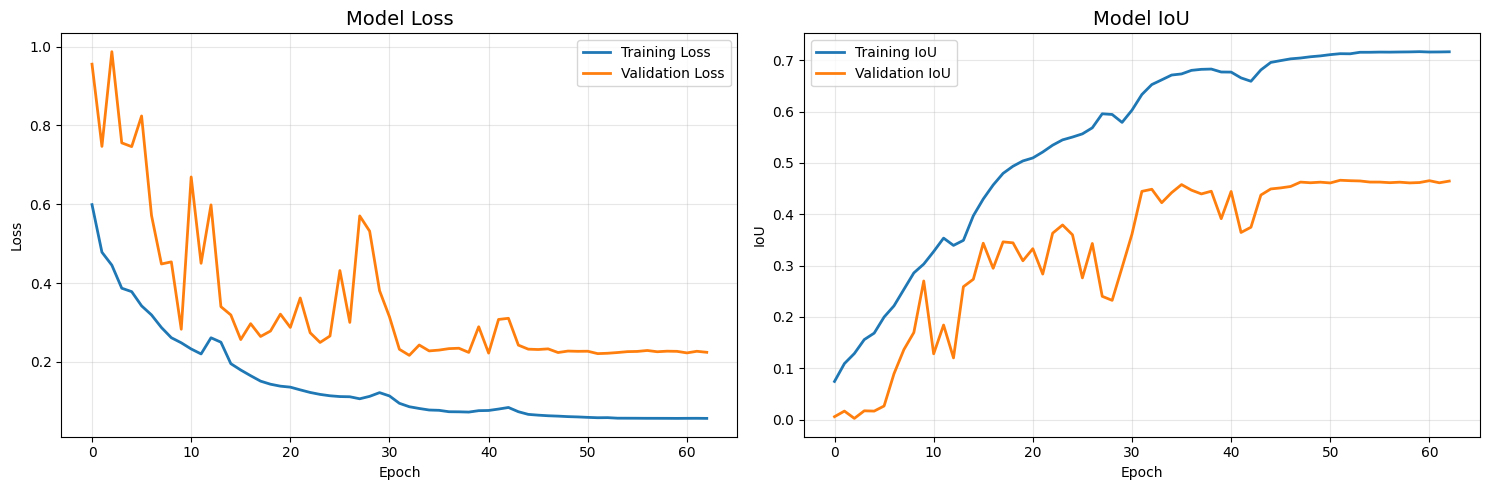



Final Training Metrics:
   Final Train Loss: 0.0564
   Final Val Loss: 0.2242
   Final Train IoU: 0.7165
   Final Val IoU: 0.4647
   Best Val IoU: 0.4663




In [68]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['my_mean_iou'], label='Training IoU', linewidth=2)
    ax2.plot(history.history['val_my_mean_iou'], label='Validation IoU', linewidth=2)
    ax2.set_title('Model IoU', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.savefig("./model_iou.png", dpi=300, bbox_inches="tight")
    
    plt.tight_layout()
    plt.show()
    
    print("\n\nFinal Training Metrics:")
    print(f"   Final Train Loss: {history.history['loss'][-1]:.4f}")
    print(f"   Final Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"   Final Train IoU: {history.history['my_mean_iou'][-1]:.4f}")
    print(f"   Final Val IoU: {history.history['val_my_mean_iou'][-1]:.4f}")
    print(f"   Best Val IoU: {max(history.history['val_my_mean_iou']):.4f}\n\n")

    

plot_training_history(history)

In [58]:
def save_model(model, path="./models/model.keras"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    model.save(path)

save_model(model)

In [62]:
loaded = tf.keras.models.load_model("./models/model.keras", compile=False)
#loaded.summary()
loaded.compile(
    optimizer=tf.keras.optimizers.Adam(),   # optimizer state is gone — this is a fresh optimizer
    loss=dice_loss,
    metrics=[MyMeanIOU(num_classes=24, name='my_mean_iou')]  # set num_classes as used in training
)
#loaded.evaluate(test_datagen)
loaded.save('./model.keras')

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 660ms/step - loss: 0.1686 - my_mean_iou: 0.4745


[0.16661164164543152, 0.508198082447052]

In [64]:
def dice_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true * y_true) + tf.reduce_sum(y_pred * y_pred) - tf.reduce_sum(y_true * y_pred)
    return 1 - numerator / denominator

class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

def load_model(path="./model.keras"):
    try:
        loaded_model = tf.keras.models.load_model(
            path,
            custom_objects={"dice_loss": dice_loss, "MyMeanIOU": MyMeanIOU}
        )
        print(f"Model loaded: {path}")
        return loaded_model
    except Exception as e:
        print(f"Error loading: {e}")
        return None

new = load_model()
if new:
    print("Save/Load test done.")

Model loaded: ./model.keras
Save/Load test done.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 412 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [67]:
from IPython.display import FileLink
FileLink(r'./model.keras')

/kaggle/working/model.keras


Example 1:


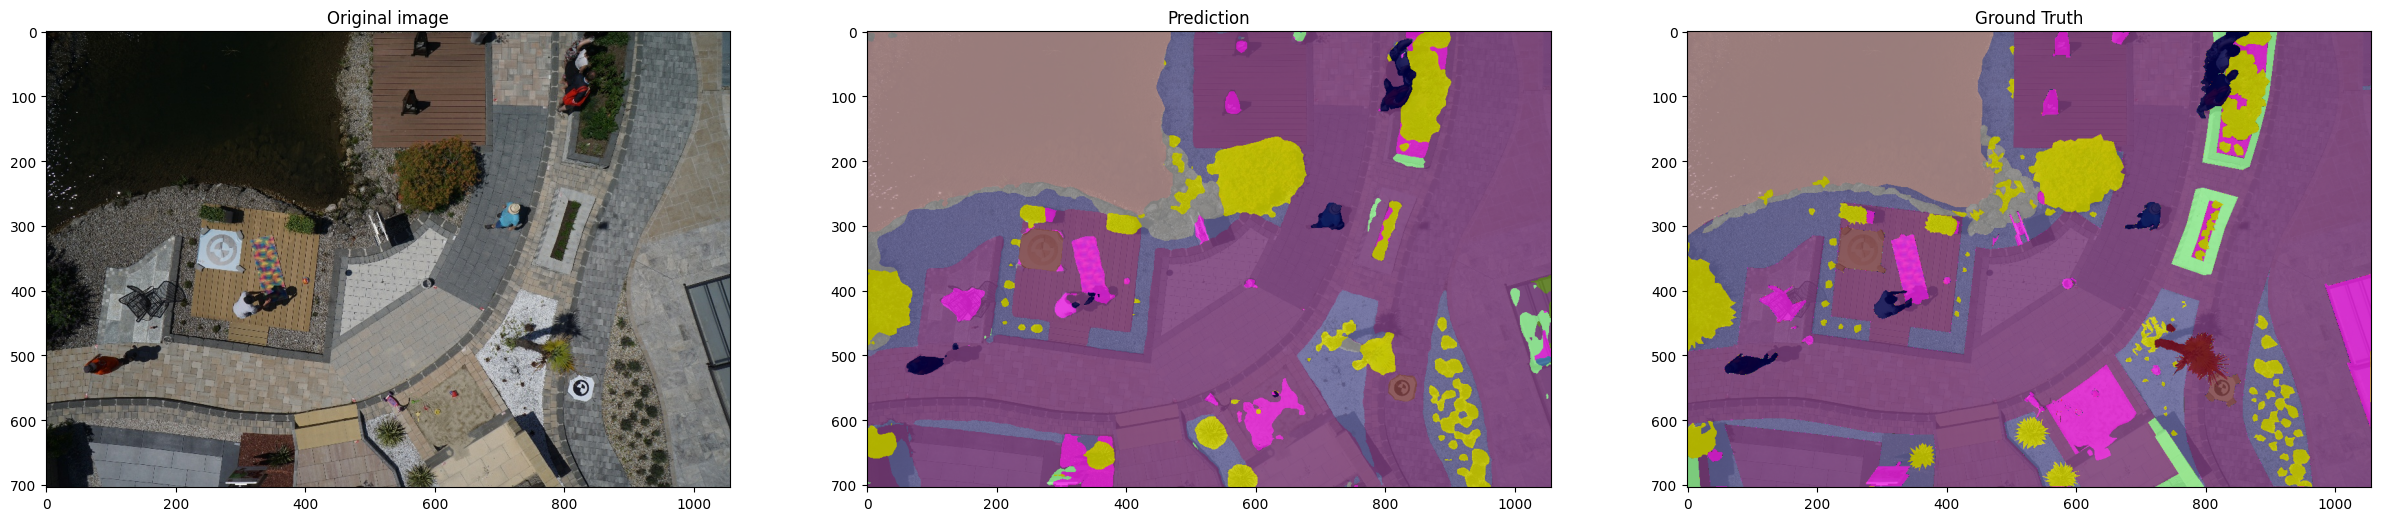

IoU: 0.8993

Example 2:


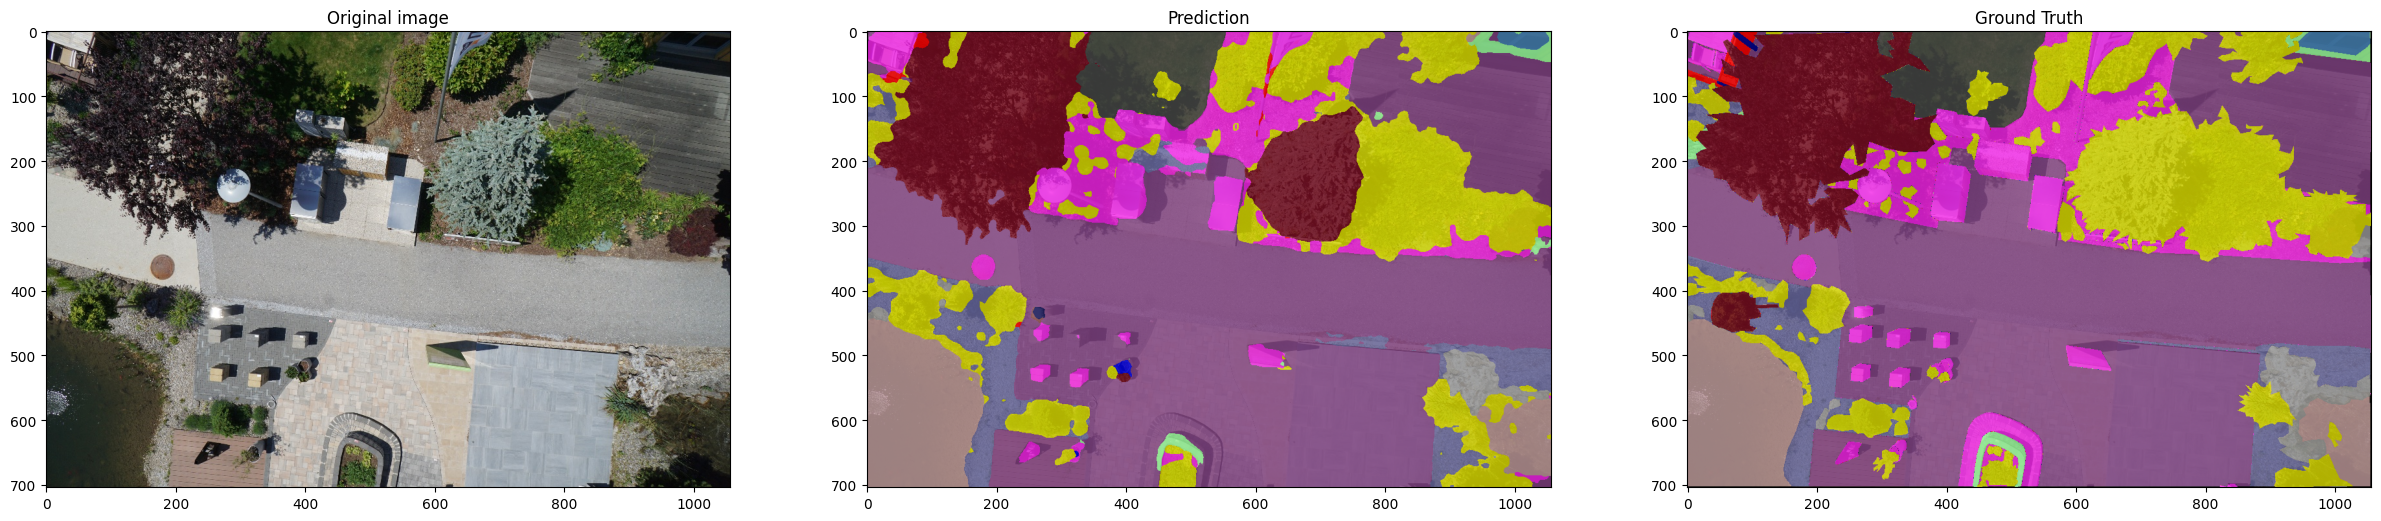

IoU: 0.8539


In [66]:
def predict_single_image(model, image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load: {image_path}")
    
    image_resized = cv2.resize(image, (1056, 704))
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)
    
    predictions = model.predict(image_batch, verbose=0)
    predicted_mask = np.argmax(predictions[0], axis=-1)
    
    return predicted_mask, image_normalized

def visualize_prediction(original_image, predicted_mask, ground_truth_mask=None):

    prediction_rgb = rgb_representations[predicted_mask]
    
    if ground_truth_mask is not None:
        
        fig, ax = plt.subplots(1, 3, figsize=(30, 30))
        
        ax[0].set_title('Original image')
        ax[0].imshow(original_image)
        
        ax[1].set_title('Prediction')
        ax[1].imshow(original_image)
        ax[1].imshow(prediction_rgb, alpha=0.8)  # Same alpha as original
        
        ax[2].set_title('Ground Truth')
        ax[2].imshow(original_image)
        gt_rgb = rgb_representations[ground_truth_mask]
        ax[2].imshow(gt_rgb, alpha=0.8)
    else:
        fig, ax = plt.subplots(1, 2, figsize=(20, 20))
        
        ax[0].set_title('Original image')
        ax[0].imshow(original_image)
        
        ax[1].set_title('Prediction')
        ax[1].imshow(original_image)
        ax[1].imshow(prediction_rgb, alpha=0.8)
    
    plt.show()

#print_legend()

for i, (X, y) in enumerate(test_datagen):
    if i >= 2: 
        break
    
    image = X[0]
    true_mask = np.argmax(y[0], axis=-1)
    
    predictions = model.predict(X[0:1], verbose=0)
    predicted_mask = np.argmax(predictions[0], axis=-1)
    
    print(f"\nExample {i+1}:")
    visualize_prediction(image, predicted_mask, true_mask)
    
    intersection = np.logical_and(predicted_mask == true_mask, true_mask > 0)
    union = np.logical_or(predicted_mask > 0, true_mask > 0)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    print(f"IoU: {iou:.4f}")